In [1]:
!pip install osmnx keplergl geopandas shapely matplotlib pandas


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import osmnx as ox

In [6]:
import networkx as nx
from keplergl import KeplerGl
import plotly.express as px

In [67]:
import pandas as pd
import geopandas as gpd

In [ ]:
from shapely.geometry import Point, MultiPoint

# Data integration

In [4]:
# define the place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

<Axes: >

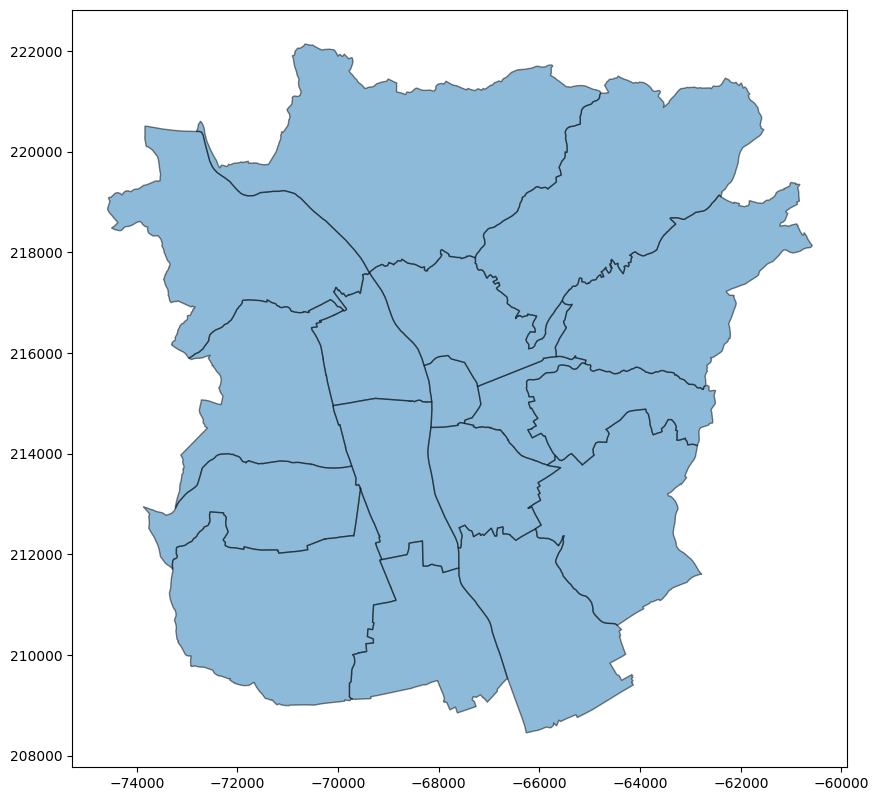

In [66]:
# Get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# Filter to only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# Drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

# plot the districts
gdf_districts.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

In [ ]:
# Import population data and merge with districts
df_population = pd.read_csv("graz_bev.csv", header=0, sep=';')
gdf_bev_districts = gdf_districts.merge(df_population, left_on='name', right_on='Bezirk')
gdf_bev_districts = gdf_bev_districts.drop(columns=['Bezirk'])

name                                             Innere Stadt
geometry    POLYGON ((-68293.14724770267 215748.1030447939...
Größe                                                    1.16
EW                                                       3184
Dichte                                                   2745
Name: 0, dtype: object


<Axes: >

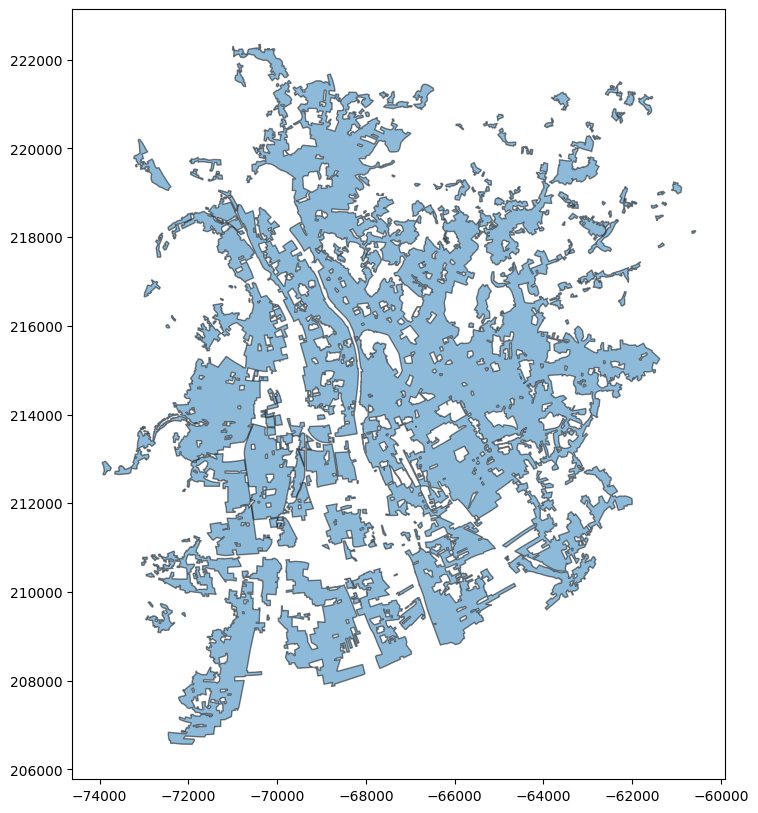

In [ ]:
# get residential areas of Graz
gdf_residential = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential.to_crs(epsg=31256)
# dissolve all residential areas into one single geometry
gdf_residential = gdf_residential.dissolve()
# plot the residential areas
gdf_residential.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

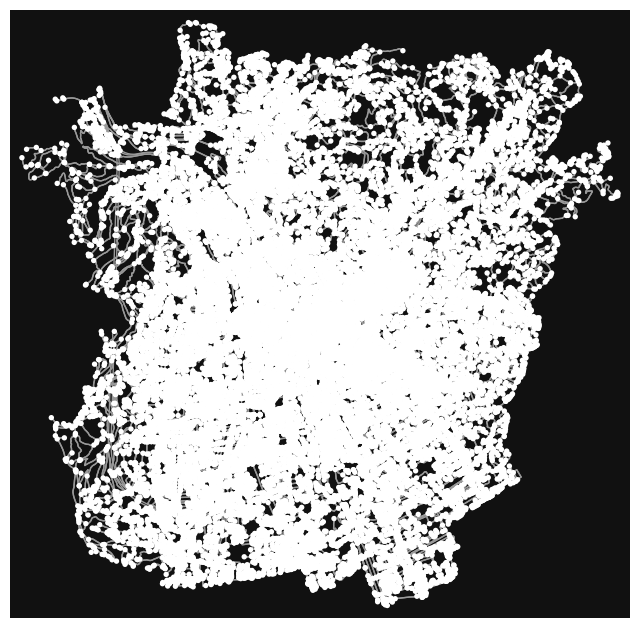

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
#if street network already exists, load it (to save time), otherwise download and save it
try:
    network_graz = ox.load_graphml("graz_street_network.graphml")
except:
    # get the street network for walking within the boundary of Graz
    network_graz = ox.graph_from_place(place_name, network_type="all")
    network_graz = ox.project_graph(network_graz, to_crs="epsg:31256")
    #save the graph
    ox.save_graphml(network_graz, filepath="graz_street_network.graphml")

# Plot the network using osmnx built-in function
ox.plot_graph(network_graz)

<Axes: >

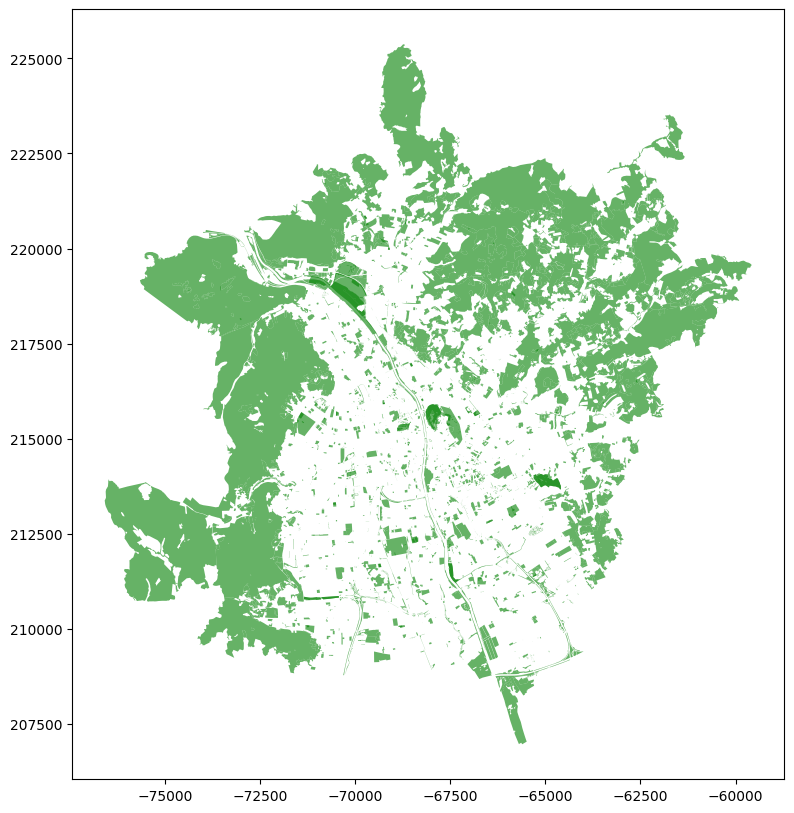

In [82]:
# Define tags for urban green spaces and parks
tags = {
    "leisure": ["park", "garden", "nature_reserve", "recreation_ground"],
    "landuse": ["forest", "grass", "meadow", "recreation_ground"]
}

tags = {
    "leisure": [
        "park",
        "garden",
        "nature_reserve",
        "recreation_ground",
        "pitch",          # often grassy sports fields
        "golf_course"
    ],
    "landuse": [
        "forest",
        "grass",
        "meadow",
        "recreation_ground",
        "allotments",
        "village_green",
        "cemetery"
    ],
    "natural": [
        "wood",
        "grassland",
        "scrub",
        "heath"
    ],
    "amenity": [
        "park",
        "playground"
        "graveyard"
    ]
}

# Download all green spaces in Graz & change the CRS
green_spaces = ox.features_from_place(place_name, tags=tags)
green_spaces = green_spaces[green_spaces.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
green_spaces = green_spaces.to_crs(epsg=31256)


# Quick visualization
green_spaces.plot(color='green', alpha=0.6, figsize=(10, 10))

In [96]:
map_green_spaces = KeplerGl(height=600)

map_green_spaces.add_data(data=green_spaces, name='green spaces')

map_green_spaces

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'green spaces': {'index': [('relation', 22203), ('relation', 1231619), ('relation', 1252339), (…

In [37]:
# Inspect data
green_spaces.info()
print(green_spaces.head())
print(green_spaces.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 4280 entries, ('relation', np.int64(22203)) to ('way', np.int64(1453823811))
Columns: 191 entries, geometry to managed
dtypes: geometry(1), object(190)
memory usage: 6.4+ MB
                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1231619  MULTIPOLYGON (((-67151.897 212730.969, -67113....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   

                 backrest                source level check_date operator  \
element  id                                                                 
relation 22203        NaN  GeoImage.at High-Res   NaN       

<Axes: >

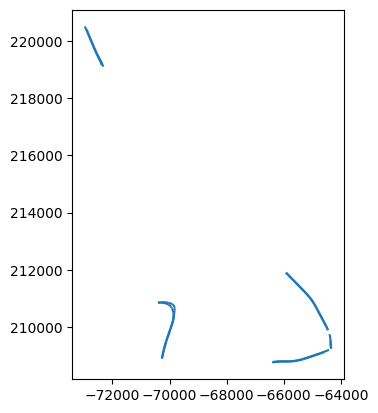

In [97]:
# Download Autobahnen and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=31256)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 20 meters around highways
highway_buffer = highways.buffer(50)

highways.plot()

# Data management

In [98]:
# Clean data
# exclude green spaces that intersect with highway buffer
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

#keep only relevant columns
green_spaces = green_spaces[['geometry', 'amenity', 'leisure', 'landuse', 'natural', 'sport', 'name']]
print(green_spaces.head())


                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1231619  MULTIPOLYGON (((-67151.897 212730.969, -67113....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   

                 leisure     landuse natural sport                      name  
element  id                                                                   
relation 22203       NaN      forest     NaN   NaN                 Leechwald  
         1231619     NaN  allotments     NaN   NaN  Heimgartenverein Schönau  
         1252339     NaN    cemetery     NaN   NaN             Urnenfriedhof  
         1252342     NaN    cemetery     NaN   NaN 

C:\Users\vitad\AppData\Local\Temp\ipykernel_15680\875778554.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


In [99]:
# Remove invalid green areas after visual inspection
green_spaces = green_spaces[~green_spaces['name'].isin(['Merkur Arena'])]
green_spaces = green_spaces[green_spaces['sport'].isna() | green_spaces['sport'].isin(['soccer', 'equestrian', 'golf', 'soccer; rugby', 'baseball', 'bmx', 'rugby', 'cricket', 'archery', 'baseball;cricket'])]

In [100]:

# Extract public-accessible green spaces (parks, urban forests, cemeteries etc.)
public_green = green_spaces[
    (green_spaces["leisure"].isin(["park", "garden", "recreation_ground"])) |
    (green_spaces["landuse"].isin(["forest", "recreation_ground", "cemetery"])) |
    (green_spaces["natural"].isin(["wood"])) |
    (green_spaces["amenity"].isin(["park", "playground", "graveyard"]))
]
# Drop private gardens without name
public_green = public_green[~((public_green["leisure"] == "garden") & (public_green["name"].isna()))]


In [101]:
# Create categories for public green spaces: parks and gardens, urban forests, cemetery
# Create a new column 'category' based on conditions
def categorize_green_space(row):
    if row['leisure'] in ['park', 'garden', 'recreation_ground'] or row['landuse'] == 'recreation_ground' or row['amenity'] in ['park', 'playground']:
        return 'park_garden'
    elif row['landuse'] == 'forest' or row['natural'] == 'wood':
        return 'urban_forest'
    elif row['landuse'] == 'cemetery' or row['amenity'] == 'graveyard':
        return 'cemetery'
    else:
        return 'other' 
public_green['category'] = public_green.apply(categorize_green_space, axis=1)
print(public_green.head())

                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   
         1407987  POLYGON ((-68707.56 217977.097, -68643.402 217...     NaN   

                 leisure   landuse natural sport                    name  \
element  id                                                                
relation 22203       NaN    forest     NaN   NaN               Leechwald   
         1252339     NaN  cemetery     NaN   NaN           Urnenfriedhof   
         1252342     NaN  cemetery     NaN   NaN         Zentralfriedhof   
         1263792    park       NaN     NaN   NaN  Johannes-Zwerger

In [102]:
map_public = KeplerGl(height=600)

map_public.add_data(data=public_green, name='public green spaces')

map_public

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'public green spaces': {'index': [('relation', 22203), ('relation', 1252339), ('relation', 1252…

In [200]:
# Exclude green spaces under 2000 m2
public_green_clean = public_green[public_green.geometry.area >= 10000]

In [201]:
map_public_c = KeplerGl(height=600)

map_public_c.add_data(data=public_green_clean, name='public green spaces')

map_public_c

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'public green spaces': {'index': [('relation', 22203), ('relation', 1252339), ('relation', 1252…

In [202]:
# Dissolve green areas by category
public_green_clean = public_green.dissolve(by='category', as_index=False)

In [203]:
public_green_all = public_green_clean.dissolve(as_index=False)
edges = ox.graph_to_gdfs(network_graz, nodes=False, edges=True)

Found 3014 access points


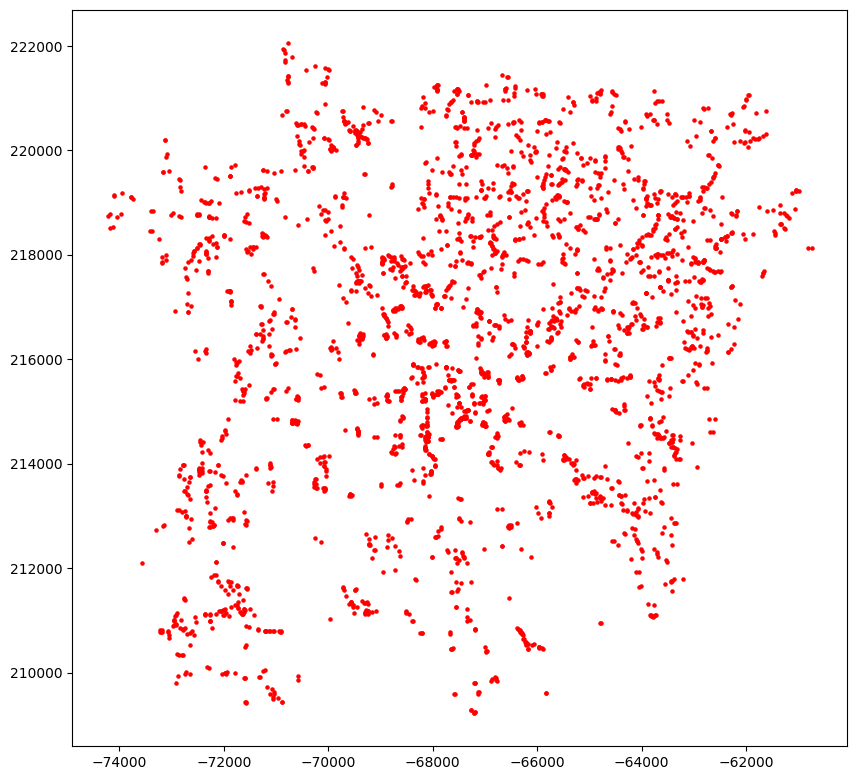

In [204]:
# Extract boundaries of parks as LineStrings
park_boundaries = public_green_all.boundary.iloc[0]  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

# Plot
access_points.plot(figsize=(10, 10), color='red', markersize=5)
print(f"Found {len(access_points)} access points")

In [205]:
map_access = KeplerGl(height=600)

map_access.add_data(data=access_points, name='access points')
map_access.add_data(data=edges, name='street network')
map_access.add_data(data=public_green_all, name='public green spaces')

map_access

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 3, 4, 5, 6, 8, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25,…

# Method 1: Euclidean Distance

In [206]:
# Create distance buffers of 300, 500 and 700 metres around the park access points
DISTS:list[int] = [100, 200, 300]  # in meters
graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon

for d in DISTS:
    # Create buffers and clip to city boundary
    access_points[f'buffer_{d}m'] = access_points.geometry.buffer(d).intersection(graz_boundary)


C:\Users\vitad\AppData\Local\Temp\ipykernel_15680\2745871685.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon


In [207]:
# Dissolve buffers
eucl_buffers = {}

for d in DISTS:
    eucl_buffers[d] = gpd.GeoDataFrame(geometry=access_points[f'buffer_{d}m']).dissolve()

In [166]:
# Intersect buffers with residential areas

# Calculate area and percentage of green residential areas


# Calculate deficient area (not within 700 m of green space) in total and for each district



In [167]:
# How much of residential areas are within each buffer?

In [168]:
# Population within each distance?

# Method 2: Network Analysis

In [ ]:
# Create distance buffers of 300, 500 and 700 metres walking distance around the park access points
# 700 m seen as distance people are willing to walk to reach a green area
DISTS:list[int] = [100, 200, 300]  # in meters

# One to all routing from all nearest nodes of access points with a maximum of dist
#calculate nearest nodes 
nearest_nodes_access = 

for d in DISTS:





In [ ]:
# Dissolve buffers

In [170]:
# Create distance buffers of 50, 150 and 300 metres walking distance around bus stations

Indicators:
total number of public parks
total area of public parks and gardens within a neighbourhood or within walking distance buffers
percentage of land covered by green spaces from the total urban area
total surface area of public parks within a neighbourhood relative to population.

# Results

In [ ]:
# Visualize green spaces in the city

In [ ]:
# Calculate the density of parks using Kernel density function

In [ ]:
# Relate data of green spaces to total area of city / districts


In [ ]:
# Population density map

In [187]:
# Map of accessbility to green areas by foot (buffers, green areas and residential areas)

map_euclid = KeplerGl(height=600)

for d in DISTS:
    map_euclid.add_data(data=eucl_buffers[d], name=f'Buffer {d}m')

map_euclid

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Buffer 100m': {'index': [0], 'columns': ['geometry'], 'data': [['MULTIPOLYGON (((15.3729605072…

In [ ]:
# Map of population density and deficient areas

In [ ]:
# Choropleth map of deficient area percentage within each district